## Loading Relevant Libraries

In [1]:
library(tidyverse)
library(readxl)
library(tidymodels)
library(forcats)
library(RColorBrewer)
library(repr)
library(ggplot2)
library(GGally)
library(knitr)
options(repr.matrix.max.rows = 6) #limits output of dataframes to 6 rows

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## Reading and Wrangling our dataset from the web into R

* Due to there being several sheets in a single excel file, we read them separately and merged them into a single dataframe called “User_Knowledge”. 
* The dataset in Sheet 1 (**Information**) has only metadata, so we will ignore this sheet.
* The dataset in Sheet 2 (**Training_Data**) has 1 column of metadata and a total of 258 rows. Therefore `select ()` is used as the argument.
* The dataset in Sheet 3 (**Test_Data**) has 1 column of metadata and a total of 145 rows. Therefore `select ()` is used as the argument.
* There was no missing value in any rows.
* The two given datasets have slightly different UNS subcategories, where the **Training_Data** has categories “*High*,” “*Medium*,” “*Low*,” and “*very_low*,” whereas the **Test_Data** has a “*Very Low*” class instead. Therefore, we change every “*very_low*” to “*Very Low*”.
* We combined the rows of both datasets to form one dataset using `rbind()`.
* The UNS column will be our target variable for this analysis. Therefore, it was converted into a factor variable using `as_factor()`.
* The resulting dataset is our wrangled `User_knowledge` dataset with **403** valuable observations.

In [2]:
#Reading the training data set from the Web into R and cleaning it
user_data_training <- download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", destfile = "user_data.xls")
user_data_training <- read_excel("user_data.xls", sheet = 2)

user_data_training <- select(user_data_training, STG:UNS) #Selecting only the required columns (not including metadata)
                    
user_data_training$UNS[user_data_training$UNS == "very_low"] <- "Very Low" #Setting the "very_low field to Very Low to match with Test_Data"

print("Table Number: 1")
user_data_training

New names:
• `` -> `...7`
• `` -> `...8`


[1] "Table Number: 1"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [3]:
#Reading the testing data set from the Web into R and cleaning it
user_data_test <- read_excel("user_data.xls", sheet = 3)
user_data_test <- select(user_data_test, STG:UNS) #Selecting only the required columns (not including metadata)
                 
print("Table Number: 2")
user_data_test

New names:
• `` -> `...7`
• `` -> `...8`


[1] "Table Number: 2"


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.10,0.50,0.26,0.05,Very Low
0.05,0.05,0.55,0.60,0.14,Low
0.08,0.18,0.63,0.60,0.85,High
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


In [4]:
#Combining both user and test data sets (they have been taken from separate excel sheets)
#robk@statmethods.net, Robert Kabacoff -. “Merging Data.” Quick-R: Merging, www.statmethods.net/management/merging.html.
User_Knowledge <- rbind(user_data_training, user_data_test)|>  #binidng rows in both the data frames using rbind
         mutate(UNS = as_factor(UNS))# mutating UNS column to be of type factor since that column needs to be predicted

User_Knowledge

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.00,0.00,0.00,0.00,Very Low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.56,0.60,0.77,0.13,0.32,Low
0.66,0.68,0.81,0.57,0.57,Middle
0.68,0.64,0.79,0.97,0.24,Middle


## Summarizing the Training Data
* Based on our data wrangling step, we have a total of **403** usable observations.
* Thus, we have made a random split of **0.70**, which means 70% of the data is split into the training set and the remaining 30% into the testing set to ensure that we have an adequate amount of observations for training and evaluating the prediction accuracy of our model.
* We also used `set.seed()` for reproducible results as `initial_split()` randomly samples from the dataframe.

In [5]:
User_Knowledge_split <- initial_split(User_Knowledge, prop = 0.7, strata = UNS) #doing the decided 70-30 split of our combined data set
user_knowledge_training <- training(User_Knowledge_split)
user_knowledge_test <- testing(User_Knowledge_split)

* Now we begin exploratory data analysis by summarizing the data into different types of tables.

In [6]:
#Counting the total number of rows in training data set
training_count <- count(user_knowledge_training) 
print("Table Number: 3")
training_count

[1] "Table Number: 3"


n
<int>
281


* Table 3 reports the number of observations in **user_knowledge_training** dataset.

In [7]:
#Counting the total number of rows in test data set
test_count <- count(user_knowledge_test) 
print("Table Number: 4")
test_count

[1] "Table Number: 4"


n
<int>
122


* Table 4 reports the number of observations in **user_knowledge_test** dataset.

In [8]:
#Counting the total number of observations of each class (training data set) to check for class imbalance (if any)
user_data_summarize <- user_knowledge_training |>
                       group_by(UNS) |>
                       summarize(Number_Of_Observations = n())
print("Table Number: 5")
user_data_summarize

[1] "Table Number: 5"


UNS,Number_Of_Observations
<fct>,<int>
Very Low,35
High,71
Low,90
Middle,85


* Table 5 reports the number of observations in each class.
* Using `group_by(UNS)`, we grouped our table by the UNS variable and then applied `n()` to count the number of observations in each class.
* It is observed that there are less cases of *"Very Low"* as compared to the other classes in our training dataset

In [9]:
# Using map_df to calculate mean of each of our predictor variables and return the result as a dataframe
user_data_mean <- select(user_knowledge_training, STG:PEG) |>
                  map_df(mean)
print("Table Number: 6")
user_data_mean

[1] "Table Number: 6"


STG,SCG,STR,LPR,PEG
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.3413665,0.3496299,0.4497509,0.4248043,0.4575552


* Table 6 reports the means of the predictor variables.
* Here, we select all the predictor variables and apply `map_df` to apply `mean()` to each of the columns in order to obtain the mean statistic for each variable.

In [10]:
verylow_avg_pred_vals <- user_knowledge_training |>
    filter(UNS == "Very Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Very Low"))

verylow_avg_pred_vals 
    
low_avg_pred_vals <- user_knowledge_training |>
    filter(UNS == "Low") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("Low"))
low_avg_pred_vals

middle_avg_pred_vals <- user_knowledge_training |>
    filter(UNS == "Middle") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c(" Middle"))
middle_avg_pred_vals

high_avg_pred_vals <- user_knowledge_training |>
    filter(UNS == "High") |>
    select( - UNS) |>
    map_df(mean) |>
    mutate(UNS =c("High"))
high_avg_pred_vals

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.2544571,0.2652857,0.3331429,0.264,0.096,Very Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3157111,0.3224333,0.4144444,0.4527778,0.2553667,Low


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3650941,0.3522588,0.4812941,0.3923529,0.5264706,Middle


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.3883239,0.4225352,0.5142254,0.5074648,0.8095775,High


* Tables above report the means of the predictor variables for the knowledge level.
* The following tables help us to compare the summary statistics for knowledge level.
* There is no clear issues in these statistics between the four classes suggesting to us that we need to conduct further analysis to distinguish the significant predictors

### Tuning our k-nn classifier

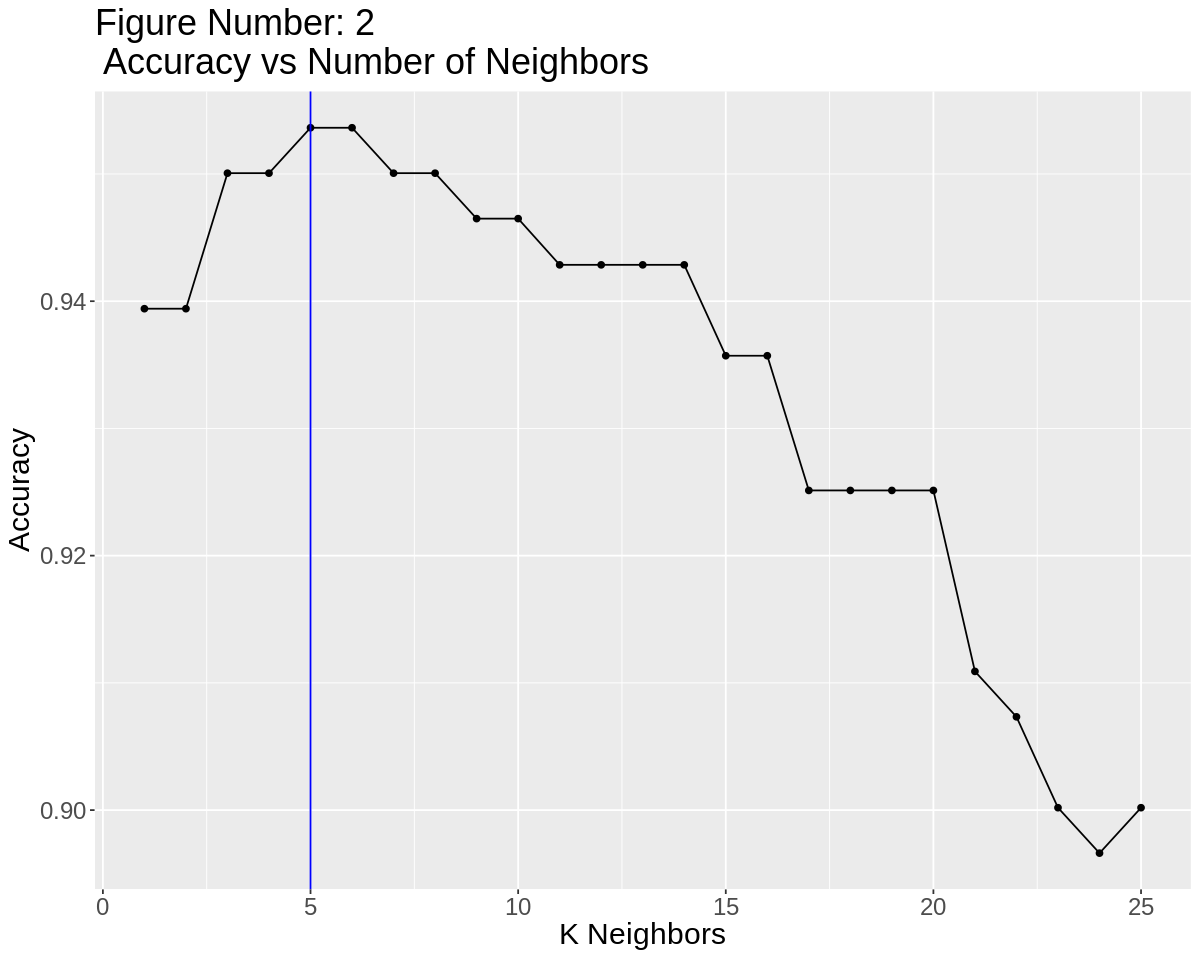

In [11]:
set.seed (2021)
options(repr.plot.height = 8, repr.plot.width = 10)

#Making the recipe with our predictor variables (LPR and PEG)
user_recipe <- recipe(UNS ~ LPR + PEG , user_knowledge_training)|>
 step_scale(all_predictors()) |> 
               step_center(all_predictors())

#Making the model using "straight-line" distance between points
#We keep the number of neighbors as tune() in order to get the optimised k value usign cross-validation
user_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

#We use 5 folds for cross-validation as we beilieve that it would not require a lot of time
user_vfold <- vfold_cv(user_knowledge_training, v = 5, strata = UNS)

#We test 25 values of k
klots <-  tibble(neighbors = seq(from = 1, to = 25, by = 1))

#We put it all together in a workflow
user_metrics <- workflow() |>
                add_recipe(user_recipe) |> #adding the recipe
                add_model(user_model) |> #adding the model
                tune_grid(resamples = user_vfold, grid = klots) |> #using tune_grid as we use cross-validation
                collect_metrics() #collecting the metrics of our cross validation

#Using the metric fucntion to find the accuracy of our classifier
user_accuracy <- user_metrics |> 
                 filter(.metric == "accuracy") #Filtering the column by "accuracy"

#Plotting the k values (number of neighbors) and the corresponding accuracy to get an optimized k value
cross_val_plot <- ggplot(user_accuracy, aes(x = neighbors, y = mean)) + 
                  geom_point() +
                  geom_line() +
                  geom_vline(xintercept = 5, colour = "blue")+
                  labs(x = "K Neighbors", y = "Accuracy") +
                  ggtitle("Figure Number: 2 \n Accuracy vs Number of Neighbors") +
                  theme(text = element_text(size = 18))

cross_val_plot


# This visualization suggests that K=5 provides the highest and the most omptimal accuracy.

* We now conduct the K-NN classification analysis on our dataset with predictors: **LPR** and **PEG**
* To do this, we:
1. Define a recipe with the predictors:**LPR** and **PEG**. We further scale and center our predictors.
2. Define the specification for our k-nn model. We use `tune()` for the neighbours argument because we will first tune our model to choose the best k-value for our model.
3. Perform cross-validation with 5 folds. This is because our dataset is not too large so 20% of the data for validation is considerably accurate.
4. Create a workflow adding the recipe and the model and applying the `tune_grid()` function for cross-validation. We then collect the resulting accuracies with the `collect_metrics()` function.
5. Finally, in we plot the accuracies against the neighbours in order to visualize the most stable k nearest neighbour.
The above graph demonstrates that **k = 5** is the most optimal value. This is because it is relatively higher than most other neighbours and does not immediately fall as we increase or decrease the neighbour by 1

###  KNN Classification

In [12]:
#Now that we know that k = 5 has the highest probability of being the highest accuracy classifier, we can make the model
user_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
             set_engine("kknn") |>
             set_mode("classification")

user_fit <-  workflow() |>
             add_recipe(user_recipe) |> #adding the recipe to the workflow
             add_model(user_spec) |> #adding the model to the workflow
             fit(data = user_knowledge_training) #fitting the workflow to our training data

user_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04626335
Best kernel: rectangular
Best k: 5

### Testing the accuracy of our KNN classification model

* Now, we conduct our KNN classification on the test set with the help of our trained model.


In [19]:
#Now that we have the model set up, we can predict the UNS class
user_predictions <- predict(user_fit, user_knowledge_test) |> 
                     bind_cols(user_knowledge_test) #adding the test data columns to our predicted column in order to see our classifier accuracy

#We use the metrics functions on the table which contains the predicted column along with the actual column to see our classsifier accuracy
user_metrics <- user_predictions |>
                metrics(truth = UNS, estimate = .pred_class) |>
                filter(.metric == "accuracy")

user_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.9754098


* It is observed in Table 7 that the accuracy of our predictions was extremely high at 97.5%.

Warning message in pal_name(palette, type):
“Unknown palette Mint”
Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



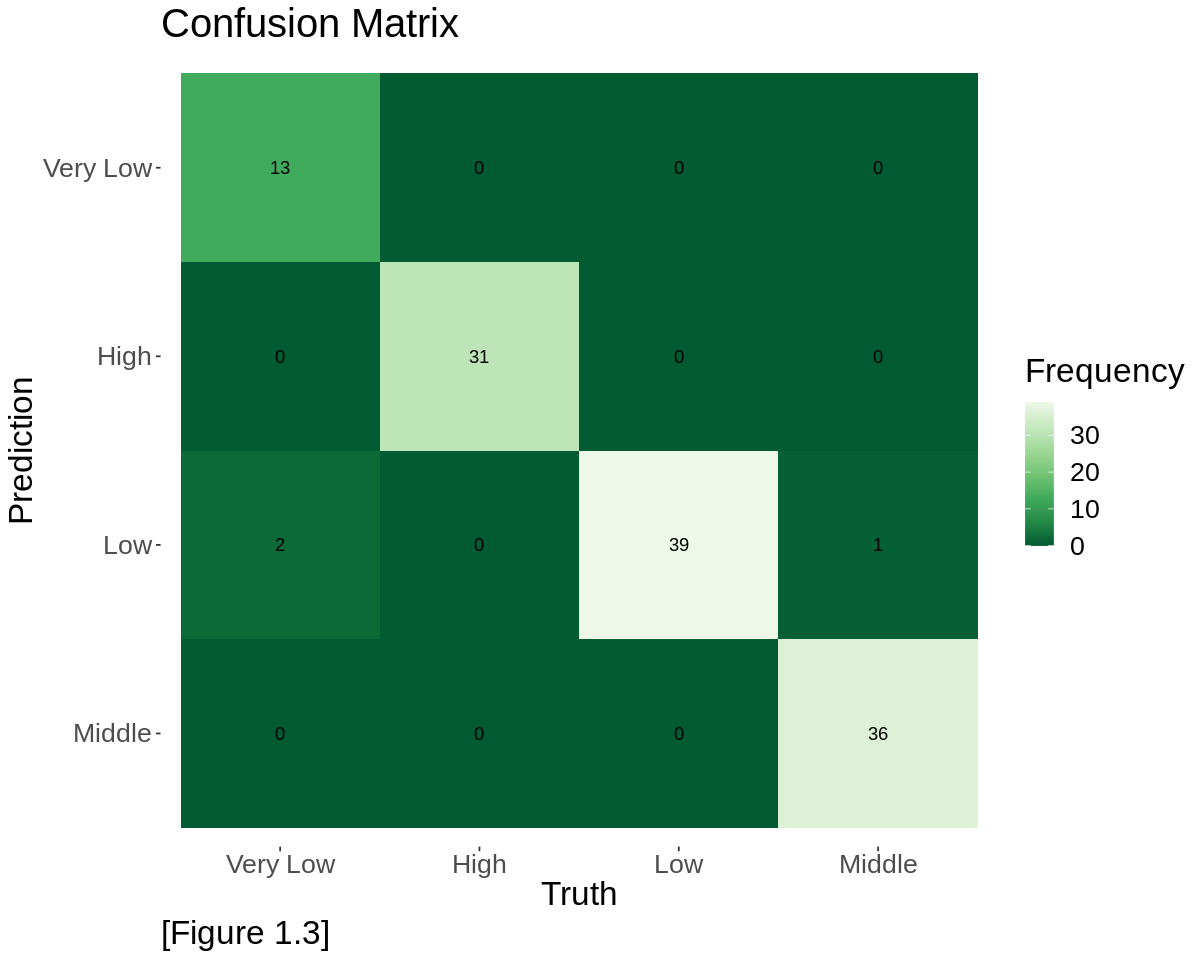

In [20]:
#We make a confusion matrix to see which classes in particular have been predicted incorrectly and whether we can afford these errors (false negatives and/or postitives) or not
user_conf <- user_predictions |>
             conf_mat(truth = UNS, estimate = .pred_class)


autoplot(user_conf, type = "heatmap") +
    scale_fill_distiller(palette = "Mint", name = "Frequency") + #color blind friendly
    labs(title = "Confusion Matrix", caption = "[Figure 1.3]") +
    theme(legend.position = "right", text = element_text(size = 20),
          plot.caption = element_text(size = 20, hjust = 0))



* To further analyse the classifer accuracy, we used conf_mat to make a confusion matrix (Table Number: 8) . It helped us to see which observations have been predicted wrong and what were the correct classes of those observations. Table Number: 8 shows that the only wrong prediction that our classifier made, actually weren’t that bad because when the truth value was ‘Very Low’, our classifier predicted “Low”, when the truth was ‘Middle’, our classifier predicted ‘Low’ and when the truth was “High”, our classifier predicted “Middle”, which is actually just one class level up or down which we believe is really not that bad and can be dealt with easily.


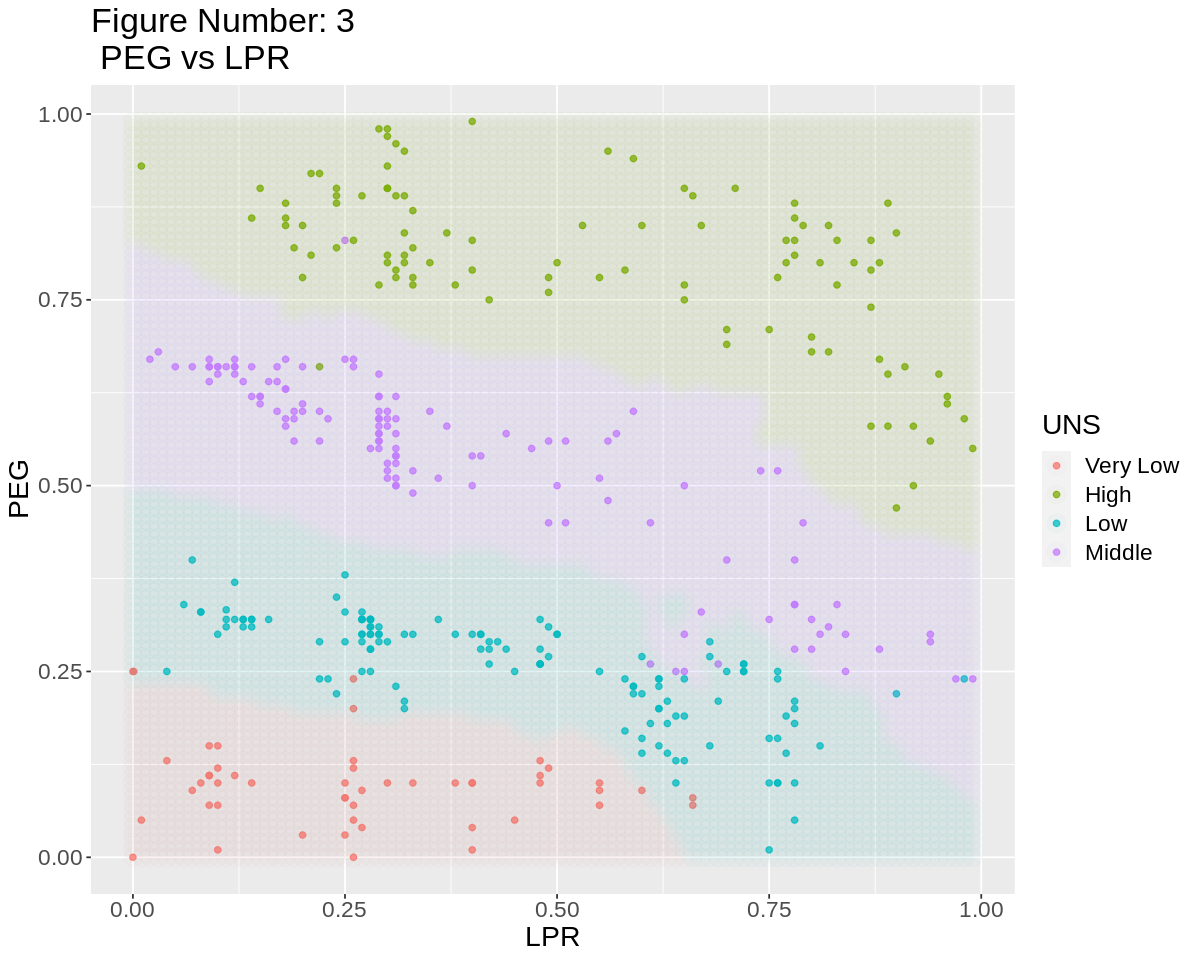

In [17]:
#Making a final plot of our classsifer which colours our classifier predictions by area

# create the grid of LPR/PEG vals, and arrange in a data frame
are_grid <- seq(min(User_Knowledge$LPR), 
                max(User_Knowledge$LPR), 
                length.out = 100)
smo_grid <- seq(min(User_Knowledge$PEG), 
                max(User_Knowledge$PEG), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(LPR = are_grid, 
                                PEG = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(user_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) %>% 
                    rename(Class = .pred_class)

#making the decided plot
plot <- ggplot() +
              geom_point(data = User_Knowledge, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = UNS), 
              alpha = 0.75) +
              geom_point(data = prediction_table, 
              mapping = aes(x = LPR, 
                            y = PEG,
                            color = Class), 
              alpha = 0.02, 
              size = 5) +
              labs(color = "UNS", 
              x = "LPR", 
              y = "PEG") +
              ggtitle("Figure Number: 3 \n PEG vs LPR") +
              theme(text = element_text(size = 17))

plot